# Class-Conditional Synthesis with Latent Diffusion Models

Install all the requirements

In [2]:
#@title Installation

# 克隆仓库
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers

# 安装 taming-transformers
!pip install -e ./taming-transformers

# 安装其他依赖
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops six

# 自动 patch taming-transformers 适配 PyTorch 2.x
import os

file_path = "./taming-transformers/taming/data/utils.py"

# 检查文件是否存在
if os.path.exists(file_path):
    with open(file_path, "r") as f:
        content = f.read()
    # 替换 'from torch._six import string_classes' -> 'import six; string_classes = six.string_types'
    if "from torch._six import string_classes" in content:
        content = content.replace(
            "from torch._six import string_classes",
            "import six\nstring_classes = six.string_types"
        )
        with open(file_path, "w") as f:
            f.write(content)
        print("[Patch applied] torch._six replaced with six.string_types")
    else:
        print("[Patch skipped] no torch._six import found")
else:
    print("File not found:", file_path)

# 添加路径
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')

# 测试导入
from taming.models import vqgan
print("vqgan imported successfully!")


fatal: destination path 'latent-diffusion' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
Obtaining file:///content/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Uninstalling taming-transformers-0.0.1:
      Successfully uninstalled taming-transformers-0.0.1
  Running setup.py develop for taming-transformers
[Patch applied] torch._six replaced with six.string_types
vqgan imported successfully!


Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [3]:
#@title Download
%cd latent-diffusion/

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt

/content/latent-diffusion
--2026-01-12 06:38:02--  https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1827378153 (1.7G)
Saving to: ‘models/ldm/cin256-v2/model.ckpt’

models/ldm/cin256-v 100%[===================>]   1.70G  20.8MB/s    in 86s     

2026-01-12 06:39:29 (20.3 MB/s) - ‘models/ldm/cin256-v2/model.ckpt’ saved [1827378153/1827378153]



Let's also check what type of GPU we've got.

In [4]:
!nvidia-smi

Mon Jan 12 06:40:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Load it.

In [5]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

In [9]:
!pip install git+https://github.com/openai/CLIP.git
!pip install kornia --quiet
!pip install einops --quiet

from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5tuhp8s1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5tuhp8s1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=5e924871b6287bfb2cc00db1727970ebbb4d565beffb80c540549f56ec932b0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-wbmgbema/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 110.4 MB/s eta 0:00:00
Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
ma

And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

Rendering 6 examples of class 'cat' (ID: 25) in 20 steps using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Rendering 6 examples of class 'dog' (ID: 187) in 20 steps using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Rendering 6 examples of class 'car' (ID: 448) in 20 steps using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Rendering 6 examples of class 'castle' (ID: 992) in 20 steps using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


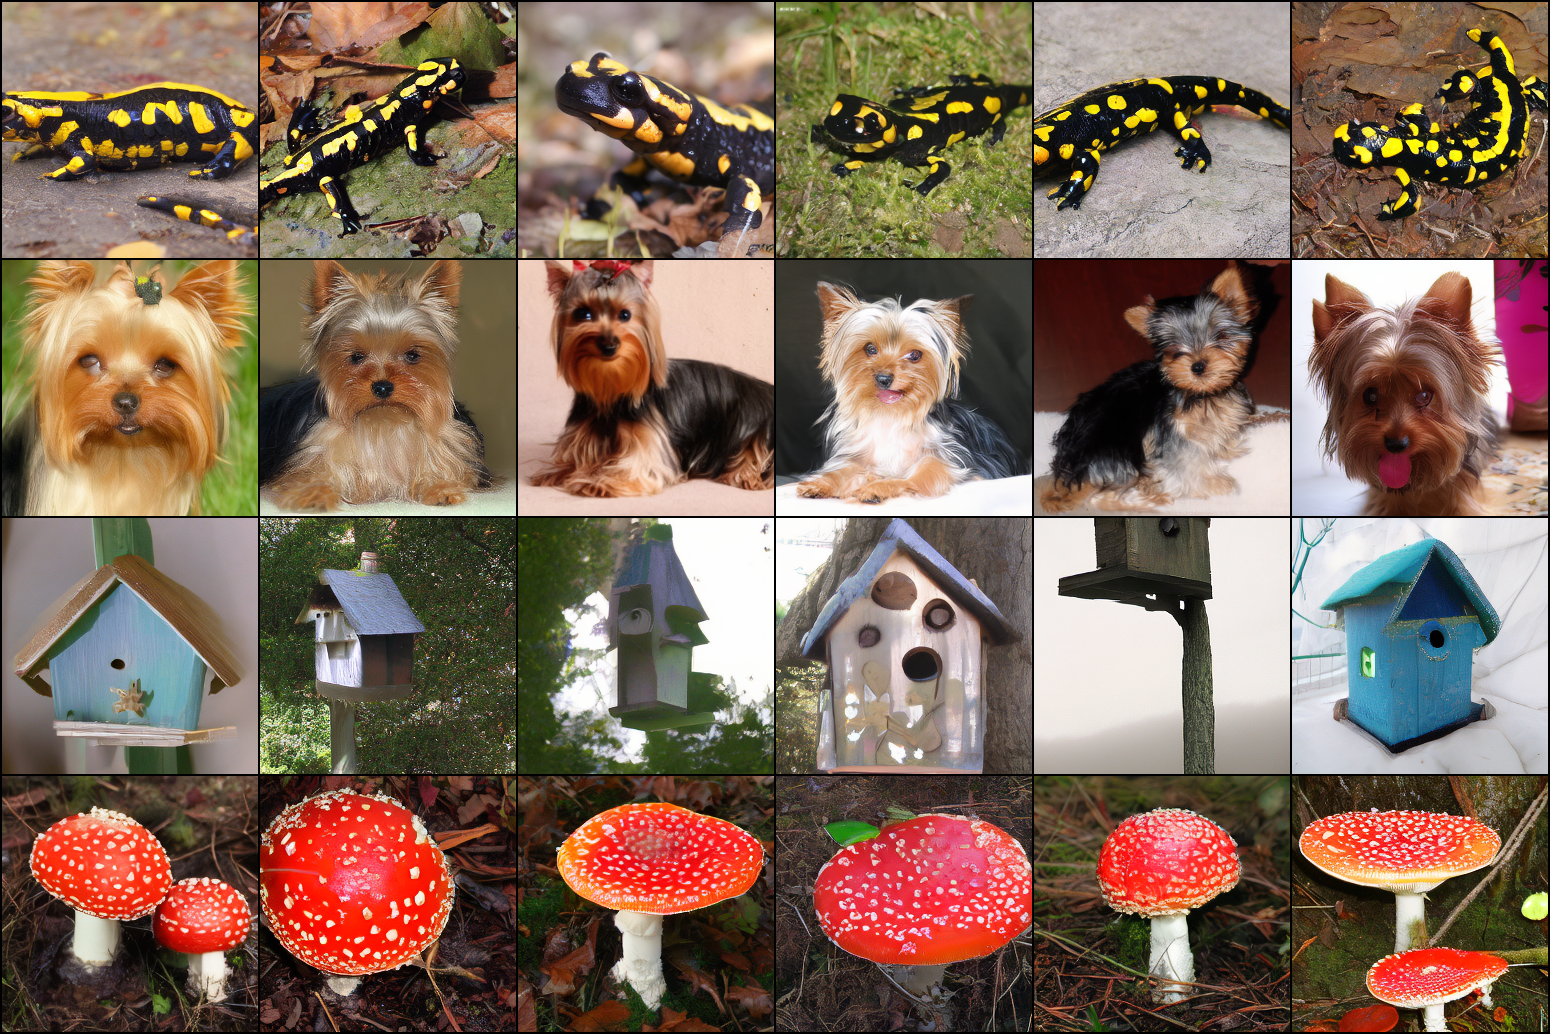

In [13]:
import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
import torch  # 补充缺失的torch导入

classes = [25, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance

class_id_to_name = {
    25: "cat",
    187: "dog",
    448: "car",
    992: "castle"
}

all_samples = list()

# 注意：这里假设model和sampler已经提前定义好
with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )

        for class_label in classes:
            # 关键修改：从字典中获取类别名称
            class_name = class_id_to_name[class_label]
            print(f"Rendering {n_samples_per_class} examples of class '{class_name}' (ID: {class_label}) "
                  f"in {ddim_steps} steps using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)

# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))